In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.sparse import csr_matrix

from implicit import als

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [5]:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) & 
                        (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]

data_train_ranker = data_val_matcher.copy()

data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [8]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

In [9]:
data_train_ranker = data_val_matcher.copy()

data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

data_train_matcher.head(4)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc,price
7,2375,26984851516,1,1085983,1,2.99,364,-0.4,1642,1,0.0,0.0,2.99
11,1364,26984896261,1,999999,1,2.19,31742,0.0,1520,1,0.0,0.0,2.19
12,1364,26984896261,1,999999,1,2.99,31742,-0.4,1520,1,0.0,0.0,2.99
13,1364,26984896261,1,999999,1,3.09,31742,0.0,1520,1,0.0,0.0,3.09


In [10]:
result_1 = data_val_matcher.groupby('user_id')['item_id'].unique().reset_index()
result_1.columns=['user_id', 'actual']

result_1.head(4)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."


In [11]:
# посмотрим количество уникальных пользователей в тестовой выборке, предварительно убрав из неё тех, кого нет в тренировочной

result_1 = result_1[result_1['user_id'].isin(data_train_matcher['user_id'].unique())]
result_1['user_id'].count()

2151

In [12]:
N_PREDICT = 50

In [13]:
result_1['als_recommender'] = result_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))

result_1['own_recommender'] = result_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))

result_1['similar_items_recommender'] = result_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))

is_extend_with_top_popular = True
result_1['own_recommender_top_popular'] = result_1['user_id'].apply(lambda x: recommender.get_own_recommendations(
    x, N=N_PREDICT, extend_with_top_popular=is_extend_with_top_popular))

In [14]:
recall_result = {'recommender': [], 'recall': []}

columns = ['als_recommender',
           'own_recommender',
           'similar_items_recommender',
           'own_recommender_top_popular'
          ]

for name in columns:
    recall_result['recommender'].append(name)
    recall_result['recall'].append(result_1.apply(lambda x: recall_at_k(x[name], x['actual'],  N_PREDICT), axis=1).mean()) 

pd.DataFrame(recall_result)

,recommender,recall
0,als_recommender,0.048461
1,own_recommender,0.065257
2,similar_items_recommender,0.033931
3,own_recommender_top_popular,0.065257


In [15]:
def get_metric_result(metric, values):
    metric_values = []
    is_extend_with_top_popular = True
    
    for v in values:
        result_1[f'own_recommender{v}'] = result_1['user_id'].apply(lambda x: recommender.get_own_recommendations(
            x, N=v, extend_with_top_popular=is_extend_with_top_popular))
        metric_values.append(result_1.apply(lambda x: metric(x[f'own_recommender{v}'], x['actual'],  v), axis=1).mean())
        
    return metric_values

In [16]:
values = [10, 25, 50, 100, 200, 300]

recall_at_k_metric = get_metric_result(recall_at_k, values)

In [17]:
for value, recall in zip(values, recall_at_k_metric):
    print(f'value: {value}, recall: {recall}')

value: 10, recall: 0.02687195384084942
value: 25, recall: 0.044119547395835505
value: 50, recall: 0.06525657038145175
value: 100, recall: 0.09604492955885034
value: 200, recall: 0.13537278412833242
value: 300, recall: 0.15718418800895068


In [18]:
precision_at_k_metric = get_metric_result(precision_at_k, values)

In [19]:
for value, precision in zip(values, precision_at_k_metric):
    print(f'value: {value}, precision: {precision}')

value: 10, precision: 0.1400278940027893
value: 25, precision: 0.09614132961413302
value: 50, precision: 0.07247791724779204
value: 100, precision: 0.05525801952580215
value: 200, precision: 0.04180381218038137
value: 300, precision: 0.03429257709592424


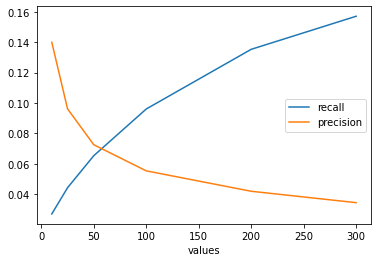

In [20]:
plt.plot(values, recall_at_k_metric, label='recall')
plt.plot(values, precision_at_k_metric, label='precision')
plt.xlabel('values')
plt.legend()
plt.show();

Если в задачах бизнеса стоит баланс метрик, то оптимальным значением k для recall будет находящееся на стыке с k precision. В данном случае чуть больше 50 (около 58). Если бы нужно было максимизировать recall, то от 300 и выше.

### Задание 2

В процессе(